# Traffic Image Classification

- Author: Kevin Chuang [@k-chuang](https://github.com/k-chuang)
- Date: 10/12/2018
- Description: Develop predictive models that can determine, given an image of traffic, which one of the 11 classes it is.

----------

## Overview

- **Introduction / Abstract**
- **Load libraries & get data**
    - Split data to training and test set
        - stratified sampling based on certain feature(s) or label(s)
- **Exploratory Data Analysis**
    - Discover and visualize the training data to gain insights
- **Data Preprocessing**
    - Prepare data for ML algorithms
    - Write pipelines using transformers to do automated feature engineering:
        - Data scaling
        - Impute missing data (or remove)
        - Feature extraction
            - Create new dimensions by combining existing ones
        - Feature selection
            - Choose subset of features from the existing features
- **Model Selection & Training**
    - Use K-Folds Cross-Validation to select top 2 to 5 most promising models
        - Do not spend too much time tweaking hyperparameters
    - Typical ML models include kNN, SVM, linear/logistic regression, ensemble methods (RF, XGB), neural networks, etc.
    - [Optional] Save experimental models to pickle file.
- **Model Tuning**
    - `GridSearchCV`, `RandomSearchCV`, or `BayesSearchCV`
        - `GridSearchCV`: brute force way to search for 'best' hyperparameters
        - `BayesSearchCV`: smart way to use Bayesian inference to optimally search for best hyperparameters
- **Model Evaluation**
    - Final evaluation on hold out test set
    - If regression, calculate 95% confidence interval range
        - t score or z score to calculate confidence interval
- **Solution Presentation and/or submission**
    - What I learned, what worked & what did not, what assumptions were made, and what system's limitations are
    - Create clear visualizations & easy-to-remember statements
- **Deployment**
    - Clean up and concatenate pipleines to single pipeline to do full data preparation plus final prediction
    - Create programs to monitor & check system's live performance    

## Introduction / Abstract

Traffic congestion seems to be at an all-time high. Machine Learning methods must be developed to help solve traffic problems. In this assignment, you will analyze features extracted from traffic imagesdepicting different objects to determine their type as one of 11 classes, noted by integers 1-11: car, suv, small_truck, medium_truck, large_truck, pedestrian, bus, van, people, bicycle, and motorcycle. The object classes are heavily imbalanced. For example, the training data contains 10375 cars but only 3 bicycles and 0 people. Classes in the test data are similarly distributed.

The input to your analysis will not be the images themselves, but rather features extracted from the images. An image can be can be described by many different types of features. In the training and test datasets, images are described as 887-dimensional vectors, composed by concatenating the following features:

- **512 Histogram of Oriented Gradients (HOG) features**
    - HOG counts occurrences of gradient orientation in localized portions of an image
    - In HOG feature desciptors, the distribution ( histograms ) of directions of gradients ( oriented gradients ) are used as features. 
    - Gradients ( x (vertical) and y (horizontal) derivatives ) of an image are useful because the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and we know that edges and corners pack in a lot more information about object shape than flat regions.
- **256 Normalized Color Histogram (Hist) features**
    - Histogram gives intensity of distribution of an image
    - Get intuition about contrast, brightness, intensity distribution etc of that image
- **64 Local Binary Pattern (LBP) features** 
    - LBP looks at points surrounding a central point and tests whether the surrounding points are greater than or less than the central point (i.e. gives a binary result).
    - Used for classifying textures (edges, corners, etc.)
- **48 Color gradient (RGB) features**
    - Color gradient measures gradual change/blend of color within an image
- **7 Depth of Field (DF) features**
    - Depth of Field is the distance about the plane of focus (POF) where objects appear acceptably sharp in an image
        - the distance between the nearest and the furthest objects that give an image judged to be in focus in a camera.

### HOG Visualizations

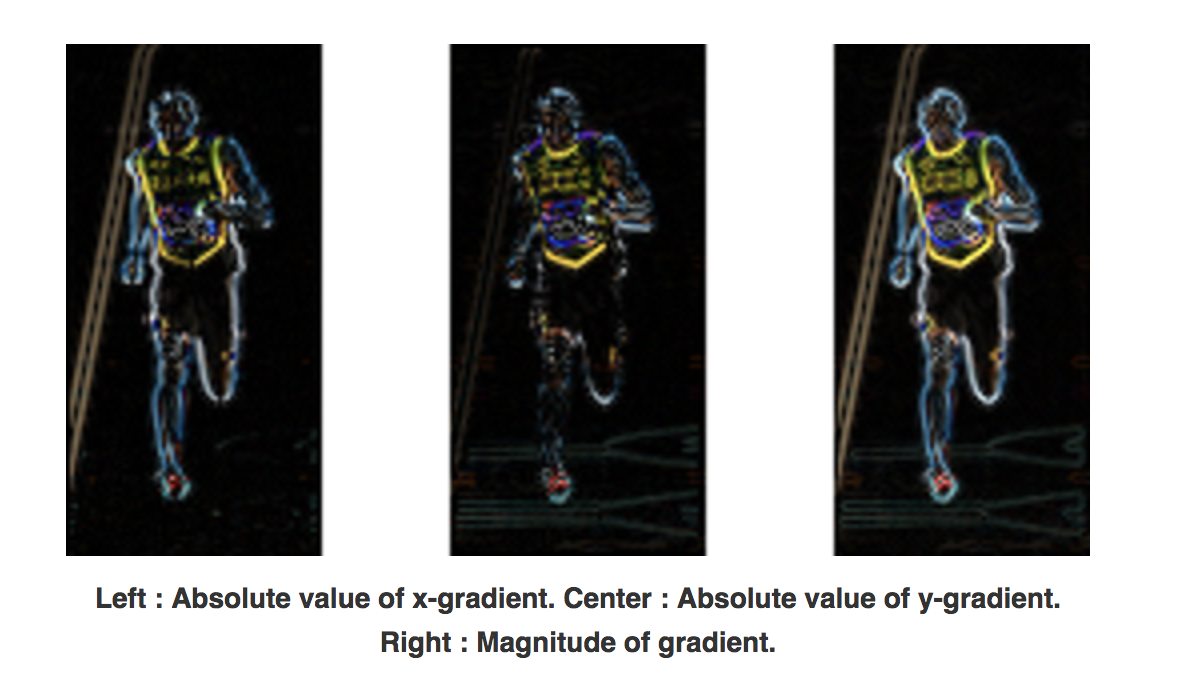

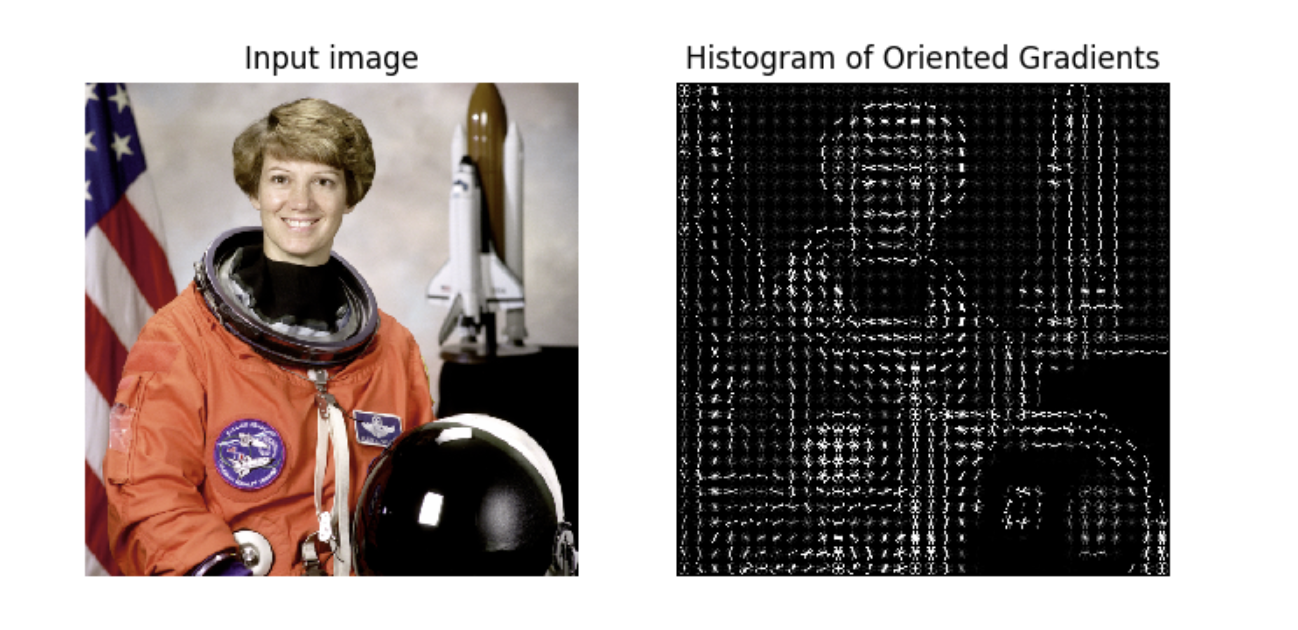

In [1]:
from IPython.display import Image, display

display(Image(filename='images/HOG_vis1.png', width=500, height=100))
display(Image(filename='images/HOG_vis4.png', width=500, height=100))
# display(Image(filename='images/HOG_vis2.png', width=500, height=100))
# display(Image(filename='images/HOG_vis3.png', width=500, height=50))

### Normalized Color Histogram Visualization

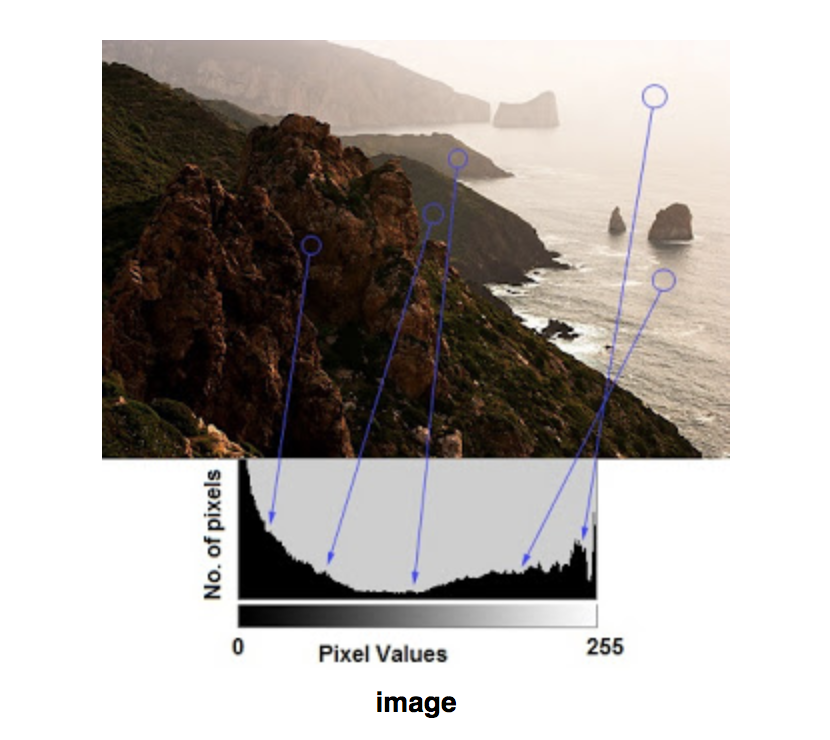

In [2]:
display(Image(filename='images/color_histogram_vis1.png', width=500, height=100))

### Local Binary Pattern (LBP) Visualization

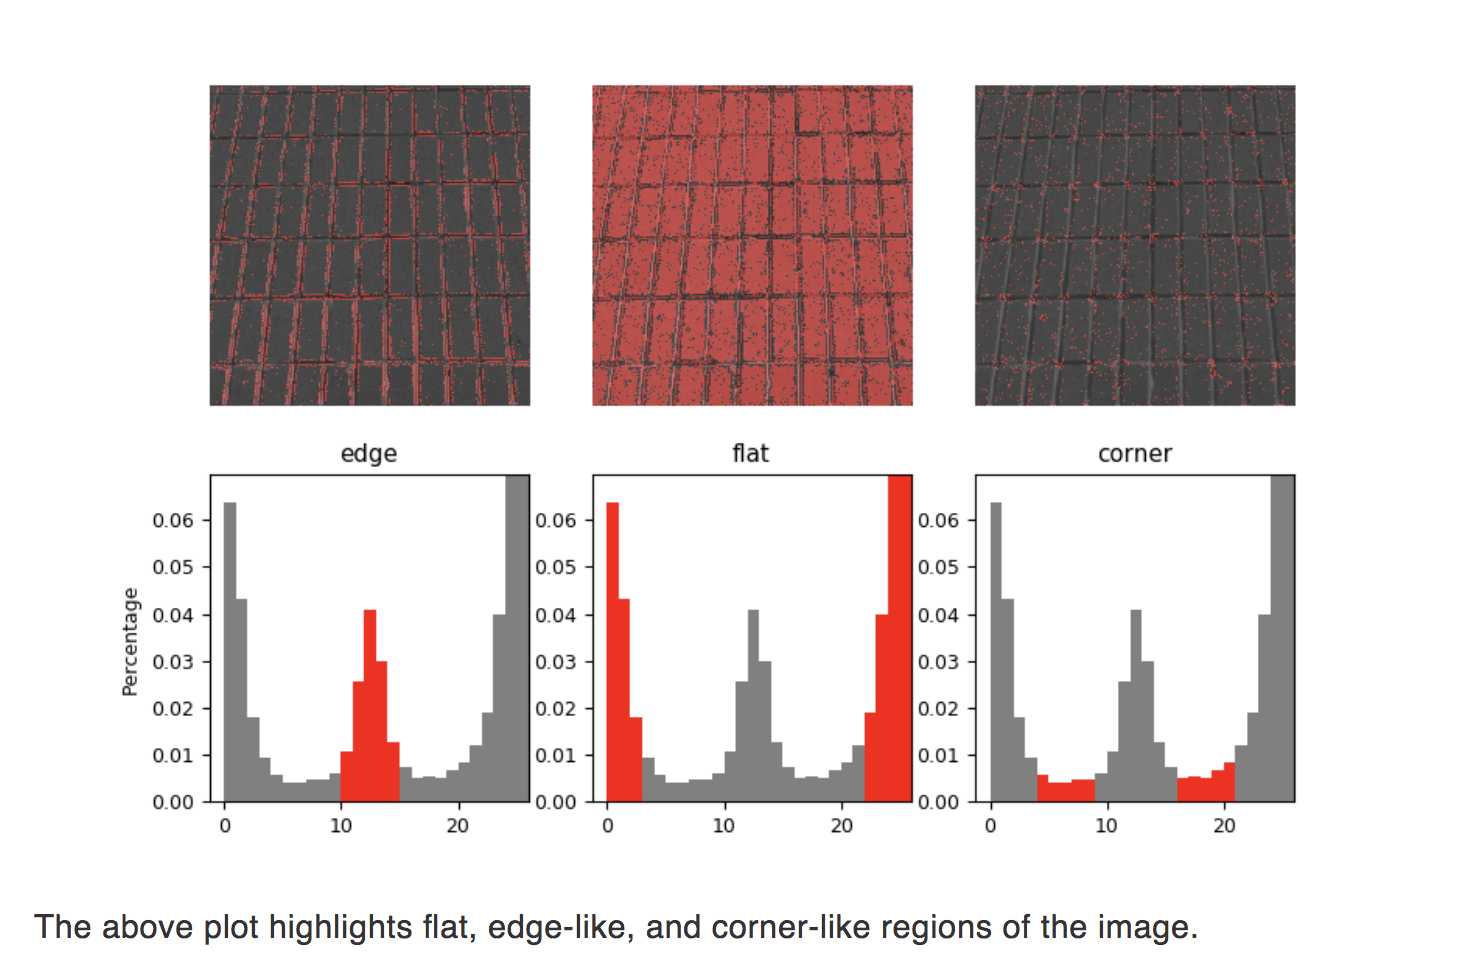

In [3]:
display(Image(filename='images/lbp_vis1.png', width=500, height=100))

## Load libraries & data

- Load important libraries
- Load (or acquire) associated data
- Split data into training and test set
    - Based on either feature importance or class imbalance, use *stratified sampling* to split data to keep porportion even for training set and test set.

In [4]:
__author__ = 'Kevin Chuang (https://www.github.com/k-chuang)' 

# Version check
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Algorithms
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
import lightgbm as lgb


# Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Manifold Learning
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, chi2, RFECV, SelectFromModel

# Metrics 
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score

# Model Selection & Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space  import Real, Categorical, Integer

# Decomposition
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA, NMF, FactorAnalysis, FastICA

# Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Clustering
from sklearn.cluster import KMeans

# Mathematical Functions
import math

# Utils
from collections import Counter

# Statistics
from scipy import stats

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

The scikit-learn version is 0.20.0.


In [5]:
train_features_df = pd.read_csv('data/train.dat', sep='\s', header=None) 
train_labels_df = pd.read_csv('data/train.labels', header=None, names=['Labels'])
test_df = pd.read_csv('data/test.dat', sep='\s', header=None) 
submission_df = pd.read_csv('data/format.dat', header=None, names=['Labels'])

In [6]:
print('Number of total training records: %d' % train_features_df.shape[0])
print('Number of total features: %d' % train_features_df.shape[1])

Number of total training records: 21186
Number of total features: 887


In [7]:
X_train, X_eval, Y_train, Y_eval = train_test_split(train_features_df, 
                                                    train_labels_df,
                                                    test_size=0.20, 
                                                    stratify=train_labels_df,
                                                    random_state=8)

In [8]:
print('Number of training records: %d' % X_train.shape[0])
print('Number of evaluation records: %d' % X_eval.shape[0])

Number of training records: 16948
Number of evaluation records: 4238


## Exploratory Data Analysis (EDA)

- Visualize training data using different kinds of plots
- Plot dependent variables (features) against independent variable (target label)

In [9]:
# Human is label 9 & cars is label 1

Y_train['Labels'].value_counts()

1     8300
2     6117
3     1394
8      680
4      235
5      158
7       42
6       14
11       6
10       2
Name: Labels, dtype: int64

In [10]:
Y_eval['Labels'].value_counts()

1     2075
2     1529
3      349
8      170
4       59
5       40
7       10
6        4
11       1
10       1
Name: Labels, dtype: int64

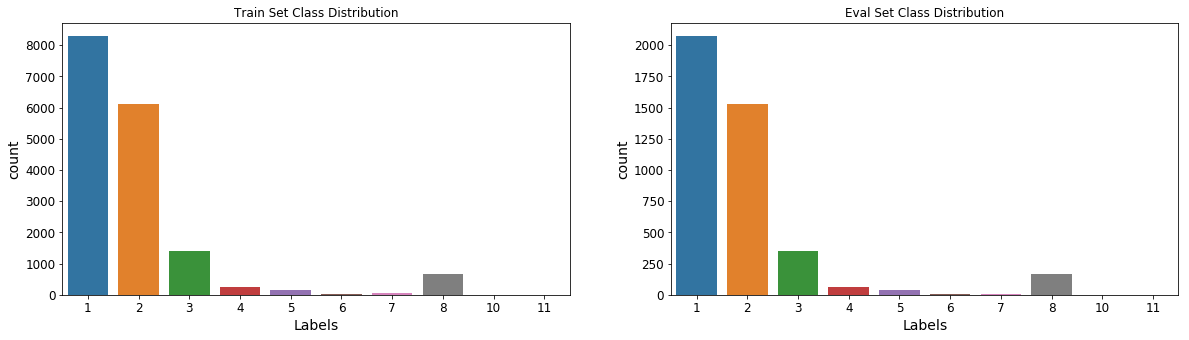

In [11]:
# Plot training and evaluation set class distributions side by side 

f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
ax1.set_title('Train Set Class Distribution');
ax2.set_title('Eval Set Class Distribution');
sns.countplot(x='Labels', data=Y_train, ax=ax1);
sns.countplot(x='Labels', data=Y_eval, ax=ax2);

## Data Preprocessing / Feature Selection

- Use `StandardScaler`
    - Standardize features by removing the mean and scaling to unit variance
- Trying out different feature selection techniques:
    - PCA
    - VarianceThreshold
    - Chi2
- Writing pipelines to do automated feature engineering
    - Imputing missing values (or removing values)
    - Scaling data
    - Transforming objects (strings, dates, etc.) to numerical vectors
    - Creating new features

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)
X_test_scaled = scaler.transform(test_df)

### Feature Selection

- PCA (Unsupervised feature extraction)
    - Identify the combination of attributes (principal components) that account for the most variance in the data.
    - 95% kept variance = 14 components
    - 99% kept variance = 22 components
    - 100% kept variance = 34 components
- LDA (Supervised feature extraction)
    - Identify attributes that account for the most variance between classes
    - 100% kept variance = 9 components
- Locally Linear Embedding (Non-linear dimensionality reduction)
    - Uses PCA so using 34 components
- Removing Features with low variance `VarianceThreshold`
    - Throw away features with 0 variance
        - remove the features that have the same value in all samples.
- Tree-based feature selection
    - Use a meta-estimator to determine/learn feature importances, and use for feature selection
- L1-based feature selection (Lasso Regularization)
    - Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero.
    - For SVMs, parameter C controls the sparsity: the smaller C the fewer features selected. 
- More to be added...

In [13]:
# # PCA: view where to cut off the number of components
# for k in np.arange(1,25):
#     print('First %d component(s)' % (k))
#     pca_model = PCA(n_components=k, svd_solver='full', random_state=8)
#     pca_model.fit(X_train_scaled)
#     print('Percentage of total variance explained: %.02f%%' % (np.sum(pca_model.explained_variance_ratio_) * 100))

In [14]:
# # Let's experiment with 80%, 85%, 90%, 95%, 99% cut off 
# # To keep 100% of the variance ~ at least 34 components 

# n_comps = [7, 9, 14, 22, 34]

# pca_model = PCA(n_components=n_comps[-1], svd_solver='full', random_state=8)

# X_train_scaled_pca = pca_model.fit_transform(X_train_scaled)
# X_eval_scaled_pca = pca_model.transform(X_eval_scaled)
# print(pca_model.n_components_)

In [15]:
# # PCA with 95% of variance kept ~ 14 components

# pca_model = PCA(n_components=0.95, svd_solver='full', random_state=8)


# X_train_scaled_pca = pca_model.fit_transform(X_train_scaled)
# X_eval_scaled_pca = pca_model.transform(X_eval_scaled)
# print(pca_model.n_components_)

In [16]:
# # LDA: view where to cut off the number of components
# for k in np.arange(1,15):
#     print('First %d component(s)' % (k))
#     lda = LinearDiscriminantAnalysis(n_components=k)
#     lda.fit(X_train_scaled, Y_train)
#     print('Percentage of total variance explained: %.02f%%' % (np.sum(lda.explained_variance_ratio_) * 100))

In [17]:
# lda = LinearDiscriminantAnalysis(n_components=9)
# X_train_scaled_pca = lda.fit(X_train_scaled, Y_train).transform(X_train_scaled)
# X_eval_scaled_pca = lda.transform(X_eval_scaled)

# print(X_train_scaled_pca.shape)

In [18]:
# Variance Threshold
vt = VarianceThreshold(threshold=0.0)
X_train_scaled_pca = vt.fit_transform(X_train_scaled)
X_eval_scaled_pca = vt.transform(X_eval_scaled)

print('Number of features used... ' + str(Counter(vt.get_support())[True]))
print('Number of features ignored... ' +str(Counter(vt.get_support())[False]))

Number of features used... 48
Number of features ignored... 839


In [19]:
# # Locally Linear Embedding (Nonlinear method for dimensionality reduction)
# for k in np.arange(1,16):
#     print('First %d component(s)' % (k))
#     lle = LocallyLinearEmbedding(n_neighbors=5, n_components=k, n_jobs=6, random_state=8)
#     lle.fit(X_train_scaled)
#     print('Reconstruction Error: ', lle.reconstruction_error_)

In [20]:
# # Locally Linear Embedding (Nonlinear method for dimensionality reduction)
# # 6 components have the lowest reconstruction error in [1, 15]

# embedding = LocallyLinearEmbedding(n_neighbors=5, n_components=6, n_jobs=6, random_state=8)
# X_train_scaled_pca = embedding.fit_transform(X_train_scaled)
# X_eval_scaled_pca = embedding.transform(X_eval_scaled)

# print(X_train_scaled_pca.shape)

In [21]:
# # TruncatedSVD: view where to cut off the number of components
# for k in np.arange(1,51):
#     print('First %d component(s)' % (k))
#     t_svd = TruncatedSVD(n_components=k, random_state=8)
#     t_svd.fit(X_train_scaled)
#     print('Percentage of total variance explained: %.02f%%' % (np.sum(t_svd.explained_variance_ratio_) * 100))

In [22]:
# t_svd = TruncatedSVD(n_components=35,random_state=8)


# X_train_scaled_pca = t_svd.fit_transform(X_train_scaled)
# X_eval_scaled_pca = t_svd.transform(X_eval_scaled)
# print(X_train_scaled_pca.shape)

In [23]:
# kpca = KernelPCA(kernel="rbf", random_state=8, n_jobs=5)

In [24]:
# # Factor Analysis

# for k in np.arange(1, 51):
#     print('First %d component(s)' % (k))
#     fa = FactorAnalysis(n_components=k, random_state=8)
#     fa.fit(X_train_scaled)
#     print('Noise Variance ', np.sum(fa.noise_variance_))

In [25]:
# # First 23 component(s)
# # Noise Variance  1.4232377304573325
# fa = FactorAnalysis(n_components=23, random_state=8)


# X_train_scaled_pca = fa.fit_transform(X_train_scaled)
# X_eval_scaled_pca = fa.transform(X_eval_scaled)
# print(X_train_scaled_pca.shape)

In [26]:
# # Using an ensemble of trees to do feature selection

# # etc = ExtraTreesClassifier(n_estimators=200, random_state=8)
# etc = LinearSVC(C=1e-3, penalty="l1", dual=False)
# etc = etc.fit(X_train_scaled, Y_train)
# model = SelectFromModel(etc, prefit=True)
# X_train_scaled_pca = model.transform(X_train_scaled)
# X_eval_scaled_pca = model.transform(X_eval_scaled)

# print(X_train_scaled_pca.shape)

## Model Selection & Training

- Try different models and choose best 2-5 models
    - Use K-Fold cross-validation to validate which models are the best
- Final models chosen for hyperparameter tuning:
    - SVM, RF, kNN, LightGBM, VotingClassifier
    - Voting Classifier includes an ensemble of different types of models
        - Works best when models are independent from one another
        - Increases chance that individual models will make very different types of errors, improving ensemble's accuracy


In [ ]:
# MLP (Neural Network)

mlp = MLPClassifier(random_state=8)
mlp_scores = cross_val_score(mlp, X_train_scaled_pca, Y_train, scoring='f1_weighted', cv=5, n_jobs=5)

print('All MLP f1 scores: ', mlp_scores)
print('Mean f1 score: ', mlp_scores.mean())
print('Standard deviation f1 score: ', mlp_scores.std())

mlp.fit(X_train_scaled_pca, Y_train)

predictions = mlp.predict(X_eval_scaled_pca)

mlp_eval_acc = accuracy_score(Y_eval, predictions)
mlp_f1_score = f1_score(Y_eval, predictions, average='weighted')

print('Accuracy for evaluation set is: %.05f' % accuracy_score(Y_eval, predictions))
print('F1 score for evaluation set is: %.05f' % f1_score(Y_eval, predictions, average='weighted'))

In [ ]:
# RBF SVM

rbf_svc = SVC(C=1e3, kernel='rbf', class_weight='balanced', random_state=8)
rbf_scores = cross_val_score(rbf_svc, X_train_scaled_pca, Y_train, scoring='f1_weighted', cv=5, n_jobs=5)

print('All SVM f1 scores: ', rbf_scores)
print('Mean f1 score: ', rbf_scores.mean())
print('Standard deviation f1 score: ', rbf_scores.std())

rbf_svc.fit(X_train_scaled_pca, Y_train)

predictions = rbf_svc.predict(X_eval_scaled_pca)

rbf_eval_acc = accuracy_score(Y_eval, predictions)
rbf_f1_score = f1_score(Y_eval, predictions, average='weighted')

print('Accuracy for evaluation set is: %.05f' % accuracy_score(Y_eval, predictions))
print('F1 score for evaluation set is: %.05f' % f1_score(Y_eval, predictions, average='weighted'))

In [ ]:
# Random Forest

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=3, random_state=8)
rf_scores = cross_val_score(rf, X_train_scaled_pca, Y_train, scoring='f1_weighted', cv=5, n_jobs=5)

print('All RF f1 scores: ', rf_scores)
print('Mean f1 score: ', rf_scores.mean())
print('Standard deviation f1 score: ', rf_scores.std())

rf.fit(X_train_scaled_pca, Y_train)

predictions = rf.predict(X_eval_scaled_pca)

rf_eval_acc = accuracy_score(Y_eval, predictions)
rf_f1_score = f1_score(Y_eval, predictions, average='weighted')

print('Accuracy for evaluation set is: %.05f' % accuracy_score(Y_eval, predictions))
print('F1 score for evaluation set is: %.05f' % f1_score(Y_eval, predictions, average='weighted'))

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=2, random_state=8)
svm_clf = SVC(C=1e3, kernel='rbf', class_weight='balanced', probability=True, random_state=8)
knn_clf = KNeighborsClassifier(n_neighbors=5)
lgbm_clf = lgb.LGBMClassifier(n_estimators=200, class_weight='balanced', objective='multiclass', n_jobs=2, random_state=8)
mlp_clf = MLPClassifier(random_state=8)

voting_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), 
                ('svc', svm_clf), 
                ('knn', knn_clf), 
                ('lgbm', lgbm_clf),
               ('mlp', mlp_clf)],
    voting='soft')

voting_scores = cross_val_score(voting_clf, X_train_scaled_pca, Y_train, scoring='f1_weighted', cv=5, n_jobs=5)

print('All Voting Classifier f1 scores: ', voting_scores)
print('Mean f1 score: ', voting_scores.mean())
print('Standard deviation f1 score: ', voting_scores.std())

voting_clf.fit(X_train_scaled_pca, Y_train)

predictions = voting_clf.predict(X_eval_scaled_pca)

voting_eval_acc = accuracy_score(Y_eval, predictions)
voting_f1_score = f1_score(Y_eval, predictions, average='weighted')

print('Accuracy for evaluation set is: %.05f' % accuracy_score(Y_eval, predictions))
print('F1 score for evaluation set is: %.05f' % f1_score(Y_eval, predictions, average='weighted'))

In [ ]:
# k-nearest neighbor

knn = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_val_score(knn, X_train_scaled_pca, Y_train, scoring='f1_weighted', cv=5, n_jobs=5)

print('All KNN f1 scores: ', knn_scores)
print('Mean f1 score: ', knn_scores.mean())
print('Standard deviation f1 score: ', knn_scores.std())

knn.fit(X_train_scaled_pca, Y_train)

predictions = knn.predict(X_eval_scaled_pca)

knn_eval_acc = accuracy_score(Y_eval, predictions)
knn_f1_score = f1_score(Y_eval, predictions, average='weighted')

print('Accuracy for evaluation set is: %.05f' % accuracy_score(Y_eval, predictions))
print('F1 score for evaluation set is: %.05f' % f1_score(Y_eval, predictions, average='weighted'))

In [ ]:
# Ensemble method: Gradient boosting (Light GBM)

lgbm = lgb.LGBMClassifier(n_estimators=200, class_weight='balanced', objective='multiclass', n_jobs=2, random_state=8)
lgbm_scores = cross_val_score(lgbm, X_train_scaled_pca, Y_train, scoring='f1_weighted', cv=5, n_jobs=5)

print('All LGB f1 scores: ', lgbm_scores)
print('Mean f1 score: ', lgbm_scores.mean())
print('Standard deviation f1 score: ', lgbm_scores.std())

lgbm.fit(X_train_scaled_pca, Y_train)

predictions = lgbm.predict(X_eval_scaled_pca)

lgbm_eval_acc = accuracy_score(Y_eval, predictions)
lgbm_f1_score = f1_score(Y_eval, predictions, average='weighted')


print('Accuracy for evaluation set is: %.05f' % accuracy_score(Y_eval, predictions))
print('F1 score for evaluation set is: %.05f' % f1_score(Y_eval, predictions, average='weighted'))

In [ ]:
# Save these results to a dataframe

model_results = pd.DataFrame({
    'Model': ['Multilayer Perceptron', 'Support Vector Machines', 'KNN', 'Random Forest', 'Voting Classifier', 'LightGBM'],
    '5-Fold CV Mean F1 Score': [mlp_scores.mean(), rbf_scores.mean(), knn_scores.mean(), 
                                rf_scores.mean(), voting_scores.mean(), lgbm_scores.mean()],
    '5-Fold CV Standard Deviation': [mlp_scores.std(), rbf_scores.std(), knn_scores.std(), rf_scores.std(), 
                                     voting_scores.std(), lgbm_scores.std()],
    'Eval F1 Score':[mlp_f1_score, rbf_f1_score, knn_f1_score, rf_f1_score, voting_f1_score, lgbm_f1_score],
    'Eval Accuracy Score:': [mlp_eval_acc, rbf_eval_acc, knn_eval_acc, rf_eval_acc, voting_eval_acc, lgbm_eval_acc]})
result_df = model_results.sort_values(by='5-Fold CV Mean F1 Score', ascending=False)

result_df.to_csv('models/LLE_6_experiment.csv', index=False)

## Model Tuning

- Tune the top chosen model(s) and tune hyperparameters
    - Ideally, use Bayes Optimization `BayesSearchCV` to optimally search for best hyperparameters for the model
        - `BayesSearchCV` is from `skopt` or `scikit-optimize` library (There are many different Bayesian Optimization implementations) 
- Below are some common search spaces for ensemble algorithms (which tend to have a lot of hyperparameters), specifically:
    - Random Forest (Variation of Bagging)
    - xgboost (Gradient Boosting)
    - lightgbm (Gradient Boosting)
        - https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [27]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

In [ ]:
# kNN
knn_search_space = {
        'n_neighbors': (1, 200)
}
knn_bayes_tuner = BayesSearchCV(
    estimator=KNeighborsClassifier(n_jobs=2),
    search_spaces=knn_search_space,
    n_iter=60,
    scoring='f1_weighted',
    n_jobs=5,
    verbose=0,
    cv = 5,
    random_state=8
)


def status_print(result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(knn_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(knn_bayes_tuner.best_params_)
    print('Model #{}\nBest F1 score: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(knn_bayes_tuner.best_score_, 6),
        knn_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = knn_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv('cv_results/' + clf_name + "_cv_results.csv")

    
# Fit the model
result = knn_bayes_tuner.fit(X_train_scaled_pca, Y_train.values, callback=status_print)

In [ ]:
# Linear SVC with multiclass support (One vs Rest scheme)

svc_search_space = {
        'C': (1e-6, 1e+6, 'log-uniform'),  
#         'gamma': ['auto', 'scale']
        'gamma': (1e-6, 1e+1, 'log-uniform'),
#         'kernel': ['linear'],  # categorical parameter
}
svc_bayes_tuner = BayesSearchCV(
    estimator=SVC(class_weight='balanced', random_state=8),
#     estimator=LinearSVC(class_weight='balanced', dual=False, random_state=8),
    search_spaces=svc_search_space,
    n_iter=50,
    scoring='f1_weighted',
    n_jobs=5,
    verbose=0,
    cv = 5,
    random_state=8
)


def status_print(result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(svc_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(svc_bayes_tuner.best_params_)
    print('Model #{}\nBest F1 score: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(svc_bayes_tuner.best_score_, 6),
        svc_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = svc_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv('cv_results/' + clf_name + "_cv_results.csv")

    
# Fit the model
result = svc_bayes_tuner.fit(X_train_scaled_pca, Y_train.values, callback=status_print)

Model #1
Best F1 score: 0.000726
Best params: {'C': 6.231513535340894e-06, 'gamma': 0.0014697688118957904}

Model #2
Best F1 score: 0.064501
Best params: {'C': 0.10887554754310125, 'gamma': 3.5747145521733657e-06}

Model #3
Best F1 score: 0.151428
Best params: {'C': 0.0013268894404804476, 'gamma': 0.006100198381897297}

Model #4
Best F1 score: 0.364758
Best params: {'C': 3.9814786691907686, 'gamma': 7.2479037638335e-06}

Model #5
Best F1 score: 0.598334
Best params: {'C': 41775.537382900744, 'gamma': 0.5424247890194661}

Model #6
Best F1 score: 0.598334
Best params: {'C': 41775.537382900744, 'gamma': 0.5424247890194661}

Model #7
Best F1 score: 0.598334
Best params: {'C': 41775.537382900744, 'gamma': 0.5424247890194661}

Model #8
Best F1 score: 0.598334
Best params: {'C': 41775.537382900744, 'gamma': 0.5424247890194661}

Model #9
Best F1 score: 0.598334
Best params: {'C': 41775.537382900744, 'gamma': 0.5424247890194661}

Model #10
Best F1 score: 0.598334
Best params: {'C': 41775.537382

In [28]:
# Random Forest (Classificaton Example)

from sklearn.ensemble import RandomForestClassifier

n_features = X_train_scaled_pca.shape[1]

rf_search_space = {
    'n_estimators': (200, 800),
    'max_depth': (1, 50),  
    'max_features': (1, n_features),
    'min_samples_leaf': (1, 50),  # integer valued parameter
    'min_samples_split': (2, 50),
}

rf_bayes_tuner = BayesSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', oob_score=True, random_state=1, n_jobs=2),
    search_spaces=rf_search_space,
    n_iter=50,
#     optimizer_kwargs={'base_estimator': 'RF'},
    scoring='f1_weighted',
    n_jobs=5,
    cv=5,
    random_state = 8
)


def status_print(result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(rf_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(rf_bayes_tuner.best_params_)
    print('Model #{}\nBest F1 score: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(rf_bayes_tuner.best_score_, 6),
        rf_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = rf_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv('cv_results/' + clf_name + "_cv_results.csv")

    
# Fit the model
result = rf_bayes_tuner.fit(X_train_scaled_pca, Y_train.values, callback=status_print)

Model #1
Best F1 score: 0.318061
Best params: {'max_depth': 4, 'max_features': 22, 'min_samples_leaf': 5, 'min_samples_split': 38, 'n_estimators': 107}

Model #2
Best F1 score: 0.677975
Best params: {'max_depth': 22, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 168}

Model #3
Best F1 score: 0.677975
Best params: {'max_depth': 22, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 168}

Model #4
Best F1 score: 0.677975
Best params: {'max_depth': 22, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 168}

Model #5
Best F1 score: 0.677975
Best params: {'max_depth': 22, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 168}

Model #6
Best F1 score: 0.677975
Best params: {'max_depth': 22, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 168}

Model #7
Best F1 score: 0.677975
Best params: {'max_depth': 22, 'max_features': 5,

In [29]:
# LGB (Regression Example)

import lightgbm as lgb

lgb_search_space  = {
    'max_depth': (3, 10),
    'num_leaves': (6, 30),
    'min_child_samples': (50, 200),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'reg_lambda': (1e-9, 1000, 'log-uniform'),
    'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    'n_estimators': (50, 500),
    'scale_pos_weight': (1e-6, 500, 'log-uniform'),
    'learning_rate': (0.01, 0.2, 'uniform')
}


lgb_bayes_tuner = BayesSearchCV(
    estimator = lgb.LGBMClassifier(class_weight='balanced', 
                                   objective='multiclass', 
                                   n_jobs=3, 
                                   random_state=8),
    search_spaces = lgb_search_space,    
    scoring = 'f1_weighted',
#     optimizer_kwargs={'base_estimator': 'GBRT'},
    cv = 5,
    n_jobs = 5,
    n_iter = 50,
    random_state = 8
)

def status_print(result):
    """Status callback during bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(lgb_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(lgb_bayes_tuner.best_params_)
    print('Model #{}\nBest Log Loss: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(lgb_bayes_tuner.best_score_, 8),
        lgb_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = lgb_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv('cv_results/' + clf_name + "_cv_results.csv")

lgb_bayes_tuner.fit(X_train_scaled_pca, Y_train.values, callback=status_print)

Model #1
Best Log Loss: 0.46916202
Best params: {'colsample_bytree': 0.07555396727115554, 'learning_rate': 0.09596818789003839, 'max_depth': 4, 'min_child_samples': 162, 'n_estimators': 56, 'num_leaves': 19, 'reg_alpha': 3.272315546878636e-05, 'reg_lambda': 2.2790084773191775e-07, 'scale_pos_weight': 2.8182438878634464e-06, 'subsample': 0.8441395984251803}

Model #2
Best Log Loss: 0.46916202
Best params: {'colsample_bytree': 0.07555396727115554, 'learning_rate': 0.09596818789003839, 'max_depth': 4, 'min_child_samples': 162, 'n_estimators': 56, 'num_leaves': 19, 'reg_alpha': 3.272315546878636e-05, 'reg_lambda': 2.2790084773191775e-07, 'scale_pos_weight': 2.8182438878634464e-06, 'subsample': 0.8441395984251803}

Model #3
Best Log Loss: 0.52154899
Best params: {'colsample_bytree': 0.2676338658803696, 'learning_rate': 0.11274505030871963, 'max_depth': 3, 'min_child_samples': 81, 'n_estimators': 125, 'num_leaves': 9, 'reg_alpha': 3.9065282777021105e-06, 'reg_lambda': 7.632823597417452e-05, 

Model #26
Best Log Loss: 0.68769423
Best params: {'colsample_bytree': 0.9102202842083394, 'learning_rate': 0.17300046734879237, 'max_depth': 8, 'min_child_samples': 85, 'n_estimators': 500, 'num_leaves': 26, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 0.04827267424016239, 'subsample': 1.0}

Model #27
Best Log Loss: 0.69106173
Best params: {'colsample_bytree': 0.926847490755858, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_samples': 50, 'n_estimators': 500, 'num_leaves': 25, 'reg_alpha': 1.155367432782067e-05, 'reg_lambda': 0.013966117552904443, 'scale_pos_weight': 0.5089232006657369, 'subsample': 0.8260428121352701}

Model #28
Best Log Loss: 0.69153873
Best params: {'colsample_bytree': 0.7314803889929167, 'learning_rate': 0.16553623973424533, 'max_depth': 9, 'min_child_samples': 50, 'n_estimators': 467, 'num_leaves': 26, 'reg_alpha': 2.7274091657731814e-06, 'reg_lambda': 1e-09, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.9150158132204764}

Model #29
Best

BayesSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=3, num_leaves=31, objective='multiclass',
        random_state=8, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_iter=50, n_jobs=5, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=8,
       refit=True, return_train_score=False, scoring='f1_weighted',
       search_spaces={'max_depth': (3, 10), 'num_leaves': (6, 30), 'min_child_samples': (50, 200), 'subsample': (0.5, 1.0, 'uniform'), 'colsample_bytree': (0.01, 1.0, 'uniform'), 'reg_lambda': (1e-09, 1000, 'log-uniform'), 'reg_alpha': (1e-09, 1.0, 'log-uniform'), 'n_estimators': (50, 500), 'scale_pos_weight': (1e-06, 500, '

## Model Evaluation

- Final evaluation on the test set
- Calculation of confidence intervals using t-score or z-scores to give a range of values and confidence level